<a href="https://colab.research.google.com/github/nicholas-dinicola/Forecasting-stock-prices-based-on-semantic-analysis-of-business-news-and-social-media-posts-/blob/main/ML_Stocks%2BUSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas_datareader as pdr
from datetime import datetime
import os
from joblib import dump, load
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import time
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import tensorflow as tf
import tensorflow_hub as hub
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Mean Directional Accuracy
def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

# Load the TSLA Historical Price Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''# Tesla
start_date = "2016/01/01"
end_date = "2021/05/01"

tlsa_stock = pdr.data.get_data_yahoo("TSLA", start=start_date, end = end_date)
tlsa_stock.head(), tlsa_stock.shape'''

'# Tesla\nstart_date = "2016/01/01"\nend_date = "2021/05/01"\n\ntlsa_stock = pdr.data.get_data_yahoo("TSLA", start=start_date, end = end_date)\ntlsa_stock.head(), tlsa_stock.shape'

In [ ]:
tlsa_stock = pd.read_csv("/content/drive/MyDrive/TLSA_stock.csv")
tlsa_stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-01-04,46.276001,43.799999,46.144001,44.681999,34135500.0,44.681999
1,2016-01-05,45.377998,44.000000,45.271999,44.686001,15934000.0,44.686001
2,2016-01-06,44.009998,43.195999,44.000000,43.807999,18895500.0,43.807999
3,2016-01-07,43.688000,42.734001,42.838001,43.130001,17771500.0,43.130001
4,2016-01-08,44.088001,42.153999,43.571999,42.200001,18140500.0,42.200001


In [ ]:
tlsa_stock["Date"] = pd.to_datetime(tlsa_stock["Date"], format="%Y-%m-%d")
tlsa_stock.set_index("Date", inplace=True)
tlsa_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,46.276001,43.799999,46.144001,44.681999,34135500.0,44.681999
2016-01-05,45.377998,44.000000,45.271999,44.686001,15934000.0,44.686001
2016-01-06,44.009998,43.195999,44.000000,43.807999,18895500.0,43.807999
2016-01-07,43.688000,42.734001,42.838001,43.130001,17771500.0,43.130001
2016-01-08,44.088001,42.153999,43.571999,42.200001,18140500.0,42.200001


In [ ]:
tlsa_stock.index.min(), tlsa_stock.index.max()

(Timestamp('2016-01-04 00:00:00'), Timestamp('2021-04-30 00:00:00'))

In [ ]:
tlsa_stock.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

# Reddit Submissions

In [ ]:
tesla = pd.read_csv("/content/drive/MyDrive/reddit_queries-TSLA stock-2016-01-01-2021-05-01-submission.csv", usecols=["created", "text"])

tesla.head()

,created,text
0,2016-01-04 18:56:15,Why the TSLA Stock Price Dropped 7% Today
1,2016-01-07 17:03:55,How will the Chinese market effect TSLA stock?
2,2016-01-09 01:22:58,If you feel a stock will rise significantly wh...
3,2016-01-10 09:00:21,Some help with respective growth
4,2016-01-14 01:39:10,"New to investing - how does a stock being ""ove..."


In [ ]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11175 entries, 0 to 11174
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   created   11175 non-null  object 
 1   text      11175 non-null  object 
 2   polarity  11175 non-null  float64
dtypes: float64(1), object(2)
memory usage: 262.0+ KB


In [ ]:
# Convert the Created column to the correct datatype
tesla["created"] = pd.to_datetime(tesla["created"], format="%Y-%m-%d %X")

# Rename the column to Date eeee
tesla.rename(columns={
                      "created": "Date", 
                      "text": "Text"
                      }, 
                      inplace=True
                      )

# Delite the time from the date 
tesla["Date"] = tesla["Date"].dt.date

# Set date as the index 
#tesla.set_index("date", inplace=True)

tesla.head()

,Date,Text
0,2016-01-04,Why the TSLA Stock Price Dropped 7% Today
1,2016-01-07,How will the Chinese market effect TSLA stock?
2,2016-01-09,If you feel a stock will rise significantly wh...
3,2016-01-10,Some help with respective growth
4,2016-01-14,"New to investing - how does a stock being ""ove..."


In [ ]:
tesla.isnull().sum()

Date    0
Text    0
dtype: int64

## *Text Processing* 

In [ ]:
print(f"Original dataset: {tesla.shape}")
# Drop duplicate submissions 
tesla.drop_duplicates(subset=["Text"], inplace=True)

print(f"Dropped Duplicates: {tesla.shape}")

Original dataset: (11175, 2)
Dropped Duplicates: (9422, 2)


In [ ]:
# Drop submission containing words: I, me, my 
tesla_cleaned = tesla[~tesla["Text"].str.contains("|".join(["I", "me", "my", "Me", "My"]))]
tesla_cleaned.shape

(5564, 2)

## *Universal Sentence Encoder - Transformer Neural Network*

In [ ]:
# load the model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
# Embed the text 
embeddings = embed(tesla_cleaned["Text"])
embeddings

<tf.Tensor: shape=(5564, 512), dtype=float32, numpy=
array([[ 0.04345561, -0.11120633,  0.0392824 , ..., -0.05267137,
        -0.02853703,  0.0399259 ],
       [ 0.05424882, -0.10001907,  0.00567574, ..., -0.06127235,
        -0.01982329,  0.0527487 ],
       [ 0.03904072, -0.06860577,  0.01309198, ..., -0.09000869,
        -0.01731982,  0.01975581],
       ...,
       [ 0.04847564, -0.06918482,  0.01885642, ..., -0.11346153,
         0.00420032,  0.06121937],
       [ 0.02811335, -0.09642216, -0.03425786, ...,  0.0287071 ,
         0.00932992,  0.04918297],
       [ 0.05211926, -0.01738226, -0.03032011, ..., -0.03761018,
         0.05486578,  0.06084002]], dtype=float32)>

In [ ]:

# Similarity
sim_matrix = np.inner(embeddings, embeddings)
sim_matrix

array([[1.        , 0.6547645 , 0.46472245, ..., 0.1941283 , 0.24112667,
        0.27285296],
       [0.6547645 , 0.99999976, 0.51486653, ..., 0.2195785 , 0.25637966,
        0.24683437],
       [0.46472245, 0.51486653, 0.99999976, ..., 0.20974058, 0.18578184,
        0.16128162],
       ...,
       [0.1941283 , 0.2195785 , 0.20974058, ..., 1.        , 0.17004205,
        0.35178077],
       [0.24112667, 0.25637966, 0.18578184, ..., 0.17004205, 0.9999999 ,
        0.35338065],
       [0.27285296, 0.24683437, 0.16128162, ..., 0.35178077, 0.35338065,
        0.9999999 ]], dtype=float32)

In [ ]:
# Tensorflow embeddings to numpy array  
embeddings_array = embeddings.numpy()

# Add the arrays in a Dataframe with shape 5564, 512
df_embed = pd.DataFrame(embeddings_array)
df_embed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,0.011030,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,0.058692,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
2,0.039041,-0.068606,0.013092,0.013186,0.011777,0.053128,0.049630,-0.011028,-0.009169,-0.061917,-0.095366,-0.024638,0.013540,-0.048794,-0.053915,-0.039160,-0.027672,0.130044,0.005325,-0.014104,-0.015254,-0.058375,-0.034113,-0.013018,-0.021983,0.080600,-0.019517,-0.003290,-0.044261,-0.009982,0.001874,-0.046344,-0.029175,0.057330,-0.010548,-0.034735,-0.053951,-0.034200,0.007441,-0.017942,...,-0.010447,-0.055492,0.029378,-0.020099,0.031322,0.017011,-0.074546,-0.016870,-0.015041,-0.047478,-0.018918,-0.047059,0.024833,-0.030533,-0.017832,0.019946,-0.044420,0.051010,0.024190,0.034760,-0.059374,-0.024289,0.021733,-0.070944,0.030421,-0.037816,-0.010248,-0.047548,0.043420,-0.005086,-0.000886,-0.033570,-0.006017,0.094140,-0.009295,-0.018683,0.001048,-0.090009,-0.017320,0.019756
3,-0.009967,-0.035609,-0.008195,-0.007284,0.071491,0.080406,-0.018711,0.050389,0.049763,0.014613,-0.038105,-0.026422,-0.026849,-0.024531,-0.007536,-0.062754,-0.015467,0.037873,-0.016769,0.045723,0.013568,0.019464,-0.086083,-0.044683,0.022927,0.015548,0.028186,-0.030208,0.024603,0.013101,-0.015893,-0.024774,0.005423,0.034380,0.016798,-0.027982,-0.001000,0.020535,-0.036618,0.007104,...,-0.002111,0.004016,0.060379,0.041406,-0.057623,-0.034787,-0.091569,0.062442,-0.038889,-0.012533,0.037532,0.060343,-0.046770,-0.051474,-0.079687,-0.016569,-0.024608,0.020597,-0.033194,-0.022631,-0.035089,0.038708,-0.027579,0.072803,0.007596,-0.020384,0.006752,-0.053086,-0.039699,0.040344,0.020259,0.014487,-0.014378,0.033963,-0.031939,-0.008462,-0.016819,-0.050620,0.033360,0.070762
4,0.041209,-0.126977,0.017845,0.070324,0.053150,0.093336,0.006642,0.000792,0.052400,-0.014364,-0.056320,0.002642,0.074355,0.026473,0.011149,-0.030655,-0.082812,-0.032159,-0.019585,-0.013274,0.017406,-0.060616,-0.007950,0.003047,-0.029943,0.045619,-0.050423,0.033763,-0.051173,-0.024855,0.013357,-0.019299,-0.012811,-0.031723,-0.012873,-0.049357,-0.042473,-0.042564,0.041365,0.044715,...,0.031905,-0.046167,0.035104,0.085450,-0.003483,-0.034634,-0.075975,-0.008378,-0.053551,-0.019567,-0.036106,0.013044,-0.005139,-0.021327,-0.060650,0.033208,-0.011678,0.004247,-0.070856,-0.036247,-0.033178,0.046641,0.019139,-0.000279,0.048948,-0.087329

## *Join the Embedded Dataframe with the Reddit one*

In [ ]:
tesla_cleaned.shape, df_embed.shape

((5564, 2), (5564, 512))

In [ ]:
# Drop the original text column from the Tesla dataset 
tesla_NoText = tesla_cleaned.drop(["Text"], axis=1)

# Combine the embedded text dataset with the Tesla dataset
tesla_embed = pd.concat([tesla_NoText.reset_index(), df_embed], axis=1)

# Drop the index 
tesla_embed.drop(["index"], axis=1, inplace=True)

# Expecting a shape of 5564, 514
tesla_embed.shape == (5564, 514)

False

In [ ]:
# See the head of the embedded tesla dataset
tesla_embed

,Date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,2016-01-04,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,2016-01-07,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
2,2016-01-14,0.039041,-0.068606,0.013092,0.013186,0.011777,0.053128,0.049630,-0.011028,-0.009169,-0.061917,-0.095366,-0.024638,0.013540,-0.048794,-0.053915,-0.039160,-0.027672,0.130044,0.005325,-0.014104,-0.015254,-0.058375,-0.034113,-0.013018,-0.021983,0.080600,-0.019517,-0.003290,-0.044261,-0.009982,0.001874,-0.046344,-0.029175,0.057330,-0.010548,-0.034735,-0.053951,-0.034200,0.007441,...,-0.010447,-0.055492,0.029378,-0.020099,0.031322,0.017011,-0.074546,-0.016870,-0.015041,-0.047478,-0.018918,-0.047059,0.024833,-0.030533,-0.017832,0.019946,-0.044420,0.051010,0.024190,0.034760,-0.059374,-0.024289,0.021733,-0.070944,0.030421,-0.037816,-0.010248,-0.047548,0.043420,-0.005086,-0.000886,-0.033570,-0.006017,0.094140,-0.009295,-0.018683,0.001048,-0.090009,-0.017320,0.019756
3,2016-01-17,-0.009967,-0.035609,-0.008195,-0.007284,0.071491,0.080406,-0.018711,0.050389,0.049763,0.014613,-0.038105,-0.026422,-0.026849,-0.024531,-0.007536,-0.062754,-0.015467,0.037873,-0.016769,0.045723,0.013568,0.019464,-0.086083,-0.044683,0.022927,0.015548,0.028186,-0.030208,0.024603,0.013101,-0.015893,-0.024774,0.005423,0.034380,0.016798,-0.027982,-0.001000,0.020535,-0.036618,...,-0.002111,0.004016,0.060379,0.041406,-0.057623,-0.034787,-0.091569,0.062442,-0.038889,-0.012533,0.037532,0.060343,-0.046770,-0.051474,-0.079687,-0.016569,-0.024608,0.020597,-0.033194,-0.022631,-0.035089,0.038708,-0.027579,0.072803,0.007596,-0.020384,0.006752,-0.053086,-0.039699,0.040344,0.020259,0.014487,-0.014378,0.033963,-0.031939,-0.008462,-0.016819,-0.050620,0.033360,0.070762
4,2016-01-20,0.041209,-0.126977,0.017845,0.070324,0.053150,0.093336,0.006642,0.000792,0.052400,-0.014364,-0.056320,0.002642,0.074355,0.026473,0.011149,-0.030655,-0.082812,-0.032159,-0.019585,-0.013274,0.017406,-0.060616,-0.007950,0.003047,-0.029943,0.045619,-0.050423,0.033763,-0.051173,-0.024855,0.013357,-0.019299,-0.012811,-0.031723,-0.012873,-0.049357,-0.042473,-0.042564,0.041365,...,0.031905,-0.046167,0.035104,0.085450,-0.003483,-0.034634,-0.075975,-0.008378,-0.053551,-0.019567,-0.036106,0.013044,-0.005139,-0.021327,-0.060650,0.033208,-0.011678,0.004247,-0.070856,-0.036247,-0.033178,0.046641,0.019139,-0.000279,0.04894

In [ ]:
# Convert the Date column to a datetime object 
tesla_embed["Date"] = pd.to_datetime(tesla_embed["Date"], format="%Y-%m-%d")
tesla_embed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Columns: 513 entries, Date to 511
dtypes: datetime64[ns](1), float32(512)
memory usage: 10.9 MB


## *Join the Tesla embedded dataset with the TLSA Historical price dataset*

In [ ]:
# Create a list of all possible dates 
start_date = "2016-01-04"
end_date = "2021/05/01"
my_dates = pd.date_range(start=start_date, end=end_date)

# Store the list of dates in a dateframe 
df_date = pd.DataFrame(my_dates).rename(columns={0: "Date"})
df_date

,Date
0,2016-01-04
1,2016-01-05
2,2016-01-06
3,2016-01-07
4,2016-01-08
...,...
1940,2021-04-27
1941,2021-04-28
1942,2021-04-29
1943,2021-04-30


In [ ]:
# Merge the Date Df with the tesla Embed to obtain a dataset with all possible dates 
tesla_date_embed = df_date.merge(tesla_embed, on="Date", how="outer")
tesla_date_embed

,Date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,2016-01-04,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
4,2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,2021-04-30,0.096124,-0.113736,0.031400,0.055952,0.034415,0.001893,-0.052301,0.090091,0.047590,-0.066928,-0.006521,-0.000326,0.015918,-0.012617,0.031136,0.008900,-0.022014,0.013384,0.029436,-0.023745,0.014494,0.031067,-0.039871,-0.075966,-0.019239,-0.024861,-0.032997,-0.015750,-0.002737,-0.018983,0.041923,-0.068143,-0.024910,-0.007335,-0.019715,-0.048310,-0.021443,-0.031209,0.037334,...,0.023137,-0.021039,-0.024418,0.081669,-0.009065,-0.023042,-0.102104,-0.024408,-0.076611,-0.011579,-0.000784,-0.033904,-0.025732,0.045473,-0.038005,0.021686,0.055202,0.071206,-0.038918,0.021647,-0.012942,-0.004659,0.028206,0.065892,-0.010352,-0.098773,-0.082373,-0.050107,0.073423,-0.008891,0.012251,0.036458,-0.011934,-0.004669,0.068999,0.046711,-0.047314,-0.054470,-0.024180,-0.003716
6284,2021-04-30,0.005917,-0.095915,0.036277,0.009219,0.054792,0.060929,-0

In [ ]:
# The tlsa_stoco df is indexed by the Date and we need it for the join, 
# thereby we need to reset the index and filter the dataset only by the  variable we are interested 

tlsa_stock = tlsa_stock["Close"].reset_index()

# Left join tlsa_stock with tesla_date_embed 
tesla_merged = tesla_date_embed.merge(tlsa_stock, on="Date", how="left")
tesla_merged

,Date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Close
0,2016-01-04,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.681999
1,2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.686001
2,2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.807999
3,2016-01-07,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749,43.130001
4,2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,2021-04-30,0.096124,-0.113736,0.031400,0.055952,0.034415,0.001893,-0.052301,0.090091,0.047590,-0.066928,-0.006521,-0.000326,0.015918,-0.012617,0.031136,0.008900,-0.022014,0.013384,0.029436,-0.023745,0.014494,0.031067,-0.039871,-0.075966,-0.019239,-0.024861,-0.032997,-0.015750,-0.002737,-0.018983,0.041923,-0.068143,-0.024910,-0.007335,-0.019715,-0.048310,-0.021443,-0.031209,0.037334,...,-0.021039,-0.024418,0.081669,-0.009065,-0.023042,-0.102104,-0.024408,-0.076611,-0.011579,-0.000784,-0.033904,-0.025732,0.045473,-0.038005,0.021686,0.055202,0.071206,-0.038918,0.021647,-0.012942,-0.004659,0.028206,0.065892,-0.010352,-0.098773,-0.082373,-0.050107,0.073423,-0.008891,0.012251,0.036458,-0.011934,-0.004669,0.068999,0.046711,-0.047314,-0.054470,-0.024180,-0.003716,709.440002
6284,2021-04-30,0.005917,-0.095915,0.036277,0.009

## *Clean up the Final Dataset*

We need to obtain a dataset with only a representation of a single day for each day. Hence, we can group by date taking the mean of all the other numerical columns. 

In [ ]:
# Group by date taking the mean for the other columns 
tesla_grouped = tesla_merged.groupby("Date").mean()
tesla_grouped

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,0.011030,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.681999
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.686001
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.807999
2016-01-07,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,0.058692,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749,43.130001
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-27,0.036748,-0.064050,0.020770,0.023711,0.028461,0.039785,0.011946,-0.021782,0.003866,-0.001729,-0.058599,-0.010909,0.038639,0.004702,0.004208,-0.007143,-0.044755,0.033188,-0.011559,-0.001541,-0.001854,-0.032107,0.016191,-0.006134,0.006185,0.037061,-0.013754,0.015708,-0.037747,0.023962,-0.003169,0.006475,0.018003,-0.023645,0.003695,-0.009469,0.005332,-0.018112,0.020418,0.005505,...,-0.021406,0.006375,0.029276,-0.013574,-0.016178,0.030707,-0.005734,-0.019706,0.000747,-0.003351,-0.019091,0.009024,0.001534,-0.011578,0.005528,-0.014336,0.041471,-0.009538,-0.013726,0.005445,0.003778,-0.000229,-0.029696,0.017594,-0.027324,-0.027346,-0.041524,0.011463,-0.029961,0.013870,-0.004220,-0.032630,0.010782,0.017406,0.015569,

### *Missing Values*

In [ ]:
# Foward fill missing values 
final_tesla = tesla_grouped.fillna(method="ffill", axis=0)
final_tesla

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,0.011030,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.681999
2016-01-05,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,0.011030,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,44.686001
2016-01-06,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.031560,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,-0.070093,-0.063076,-0.036580,0.048723,0.011030,...,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926,43.807999
2016-01-07,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,0.058692,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749,43.130001
2016-01-08,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.050650,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,-0.059336,-0.018484,-0.049422,0.041077,0.058692,...,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.0525

In [ ]:
final_tesla.isnull().any().sum()

0

Text(0.5, 1.0, 'TSLA Close Stock Price')

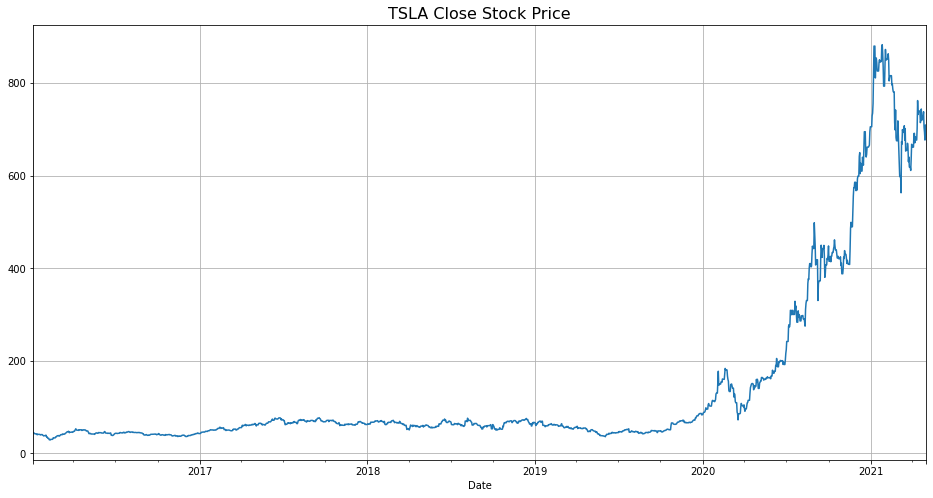

In [ ]:
final_tesla["Close"].plot(figsize=(16, 8))
plt.grid(True)
plt.title("TSLA Close Stock Price", fontsize=16)

Data after 2019/09/01 became too volatile, thereby i will not include those data in the model. 

In [ ]:
final_tesla = final_tesla[final_tesla.index < "2019/09/01"]
final_tesla.index.min(), final_tesla.index.max()

(Timestamp('2016-01-04 00:00:00'), Timestamp('2019-08-31 00:00:00'))

Text(0.5, 1.0, 'TSLA Close Stock Price')

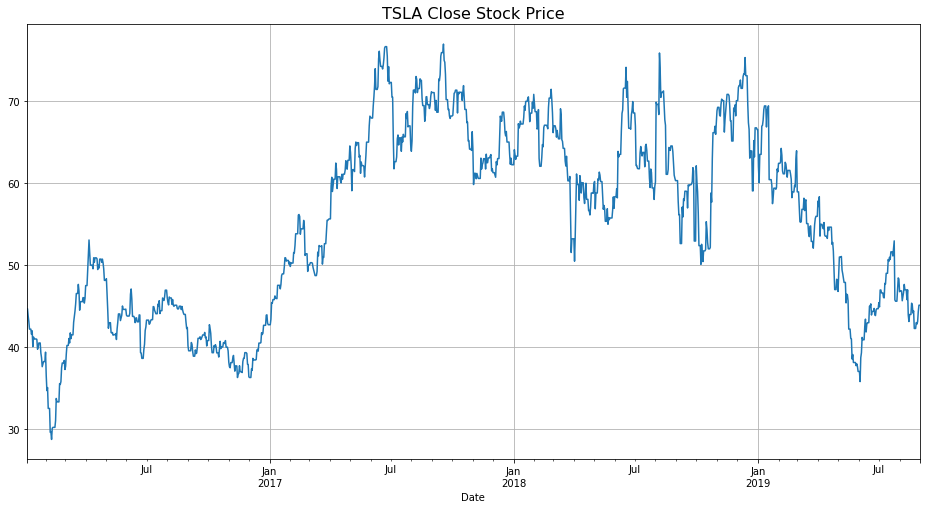

In [ ]:
final_tesla["Close"].plot(figsize=(16, 8))
plt.grid(True)
plt.title("TSLA Close Stock Price", fontsize=16)

In [ ]:
final_tesla.shape

(1336, 513)

# Stock Price + Text Embeddings + Polarity Score

# TRAIN TEST SPLIT

In [ ]:
train_set, test_set = train_test_split(final_tesla, test_size=0.1, random_state=42, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

1202 train and 134 test instances


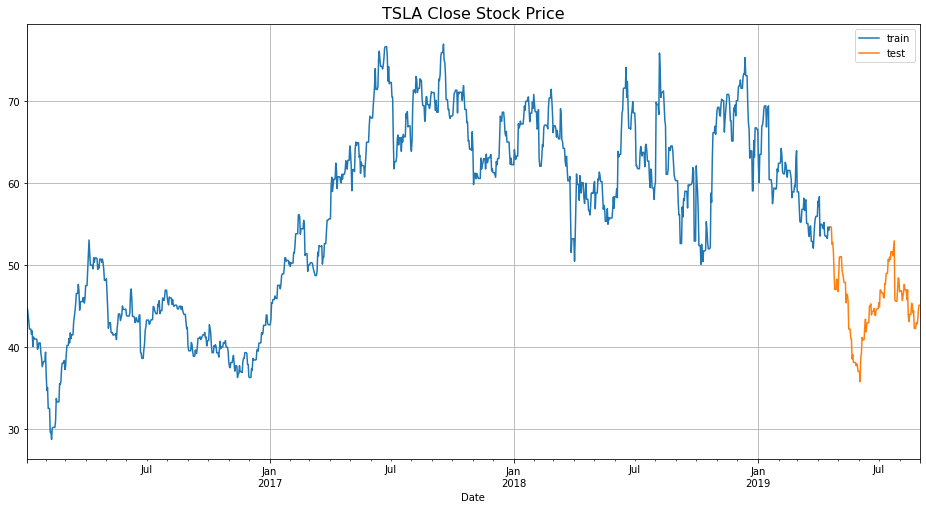

In [ ]:
pd.DataFrame({"train":train_set["Close"], "test":test_set["Close"]}).plot(figsize=(16, 8))
plt.title("TSLA Close Stock Price", fontsize=16)
plt.grid(True)

# Data Tranformation

In [ ]:
train_log = np.log(train_set["Close"])
test_log = np.log(test_set["Close"])

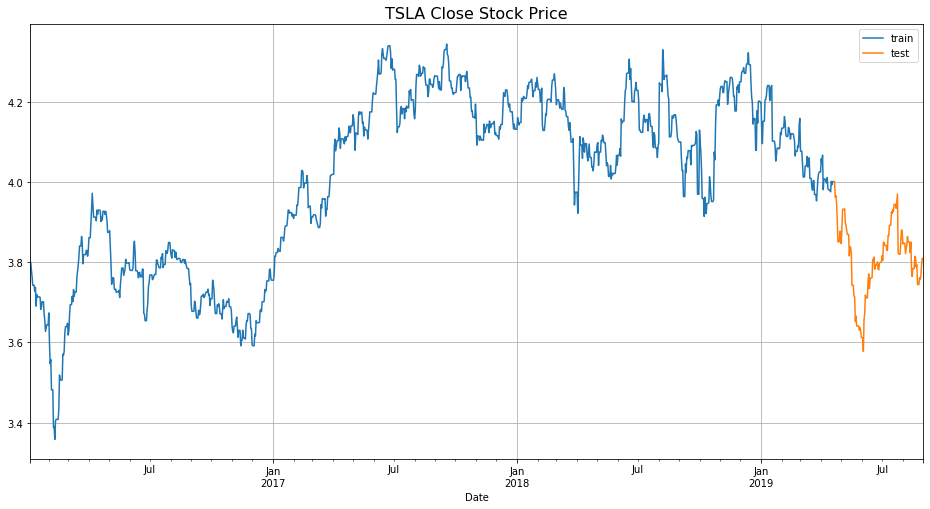

In [ ]:
pd.DataFrame({"train":train_log, "test":test_log}).plot(figsize=(16, 8))
plt.title("TSLA Close Stock Price", fontsize=16)
plt.grid(True)

In [ ]:
# Differencing 
train_diff = train_log.diff().dropna()
adf_pval = adfuller(train_diff)[1]
print(f"ADF, p-value: {adf_pval}")
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff)
print(f"KPSS, p-value: {kpss_pval}")

# Apply differencing to the test set as well 
test_diff = test_log.diff().dropna()

# chech the shape of them 
train_diff.shape, test_diff.shape

ADF, p-value: 0.0
KPSS, p-value: 0.1


((1201,), (133,))

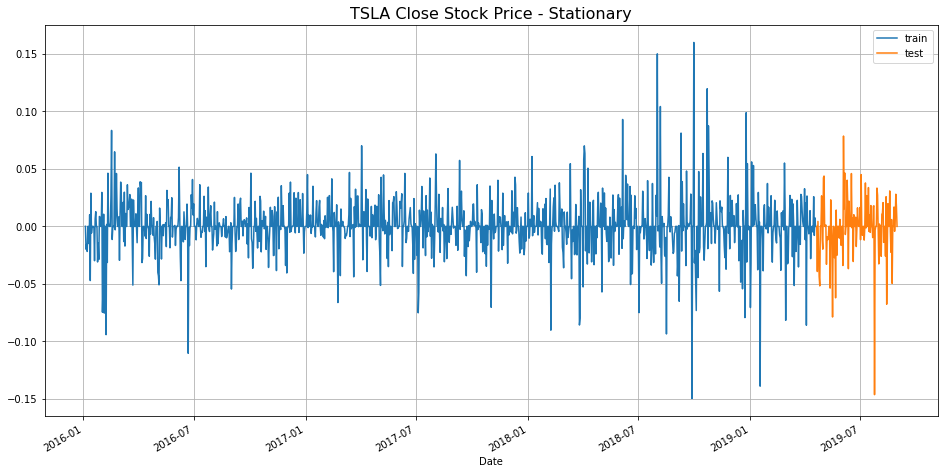

In [ ]:
pd.DataFrame({"train":train_diff, "test":test_diff}).plot(figsize=(16, 8))
plt.title("TSLA Close Stock Price - Stationary", fontsize=16)
plt.grid(True)

There still are some spikes in the data, what would happen if we did the log of them? 


In [ ]:
# 5 days - from monday to friday (stock market is closedsat and sun)
lags = 5
X_train, y_train, X_test, y_test= [], [], [], []

for x in range(lags, len(train_diff.values.reshape(-1, 1))):
    X_train.append(train_diff.values.reshape(-1, 1)[x-lags:x, 0])
    y_train.append(train_diff.values.reshape(-1, 1)[x, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

for x in range(lags, len(test_diff.values.reshape(-1, 1))):
    X_test.append(test_diff.values.reshape(-1, 1)[x-lags:x, 0])
    y_test.append(test_diff.values.reshape(-1, 1)[x, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1196, 5), (1196,), (128, 5), (128,))

In [ ]:
exog_train = train_set.drop("Close", axis=1)
exog_test = test_set.drop("Close", axis=1)

In [ ]:
X_train = pd.concat([pd.DataFrame(X_train), exog_train.reset_index()], axis=1).drop("Date", axis=1).dropna()
X_test = pd.concat([pd.DataFrame(X_test), exog_test.reset_index()], axis=1).drop("Date", axis=1).dropna()

In [ ]:
X_train.head()

,0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.000090,-0.019844,-0.015598,-0.021799,0.000000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.03156,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
1,-0.019844,-0.015598,-0.021799,0.000000,0.000000,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.03156,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
2,-0.015598,-0.021799,0.000000,0.000000,-0.015041,0.043456,-0.111206,0.039282,0.028087,0.066061,0.079261,-0.008618,0.018962,0.028969,-0.019343,-0.081356,-0.039390,0.054613,0.012854,0.003346,-0.009960,-0.084993,0.085897,0.006459,-0.048854,0.047701,-0.03156,-0.012330,-0.026006,-0.016266,0.068832,-0.057980,0.039315,-0.034920,-0.050575,-0.004674,0.021870,-0.011938,0.004367,-0.016655,...,0.007832,-0.002702,0.026996,0.062948,0.012264,-0.042302,-0.072356,0.000278,-0.072709,-0.030124,-0.028120,-0.061032,0.053824,-0.033517,-0.032044,0.023999,0.004247,0.048313,-0.060449,-0.001217,-0.080071,0.026876,0.099369,-0.072698,0.034825,-0.072104,-0.088302,-0.035769,0.076552,-0.000177,0.038172,-0.054096,-0.032111,0.105441,0.024978,0.010466,-0.009336,-0.052671,-0.028537,0.039926
3,-0.021799,0.000000,0.000000,-0.015041,0.010148,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.05065,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.066581,-0.010474,0.005702,-0.073947,-0.012903,0.051483,0.040810,0.011696,0.002026,-0.061272,-0.019823,0.052749
4,0.000000,0.000000,-0.015041,0.010148,-0.047098,0.054249,-0.100019,0.005676,0.025903,0.012255,0.061417,0.038386,0.024606,-0.032783,-0.031655,-0.081229,0.047119,-0.003646,0.025626,0.038140,-0.025968,-0.095520,0.091174,0.019447,0.036443,0.058973,-0.05065,0.053199,-0.037462,0.004868,0.088564,-0.043573,-0.008056,-0.025458,-0.022238,-0.007499,-0.020805,-0.031052,-0.016323,0.003157,...,0.032991,-0.061432,-0.072300,0.025974,-0.007853,-0.010987,-0.086263,0.047712,-0.025806,-0.021155,-0.009063,-0.009691,-0.029610,-0.052566,0.025543,-0.020149,0.001286,0.009171,-0.077861,0.005890,-0.065762,0.026287,-0.025840,-0.074235,0.059942,-0.059212,-0.060149,-0.003259,0.0

In [ ]:
X_test.head()

,0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.000000,-0.039221,0.004367,-0.020056,-0.043579,0.012351,-0.048884,-0.029511,0.002351,0.079867,0.088463,-0.041595,-0.031075,0.005357,-0.001092,-0.081590,0.061461,0.066473,0.018055,0.053832,0.022355,-0.036107,-0.089072,0.048733,0.042591,0.012833,0.009269,0.030579,0.070454,-0.017943,0.047763,0.076287,-0.024580,-0.045648,-0.006835,0.016161,0.032915,-0.006397,0.018000,-0.000712,...,0.041147,0.008765,0.032990,-0.020962,-0.019238,-0.004653,-0.035901,-0.035397,-0.041130,-0.025106,-0.002492,-0.028935,-0.035789,0.043580,-0.040088,-0.048624,-0.039557,0.082903,-0.068949,-0.042432,-0.027293,0.092440,-0.031290,0.006125,0.028106,-0.036478,-0.047552,-0.000717,0.008272,0.032810,0.054049,0.035661,-0.029676,-0.035063,0.028572,0.018392,0.013183,-0.017984,0.040852,0.055679
1,-0.039221,0.004367,-0.020056,-0.043579,-0.051755,0.012351,-0.048884,-0.029511,0.002351,0.079867,0.088463,-0.041595,-0.031075,0.005357,-0.001092,-0.081590,0.061461,0.066473,0.018055,0.053832,0.022355,-0.036107,-0.089072,0.048733,0.042591,0.012833,0.009269,0.030579,0.070454,-0.017943,0.047763,0.076287,-0.024580,-0.045648,-0.006835,0.016161,0.032915,-0.006397,0.018000,-0.000712,...,0.041147,0.008765,0.032990,-0.020962,-0.019238,-0.004653,-0.035901,-0.035397,-0.041130,-0.025106,-0.002492,-0.028935,-0.035789,0.043580,-0.040088,-0.048624,-0.039557,0.082903,-0.068949,-0.042432,-0.027293,0.092440,-0.031290,0.006125,0.028106,-0.036478,-0.047552,-0.000717,0.008272,0.032810,0.054049,0.035661,-0.029676,-0.035063,0.028572,0.018392,0.013183,-0.017984,0.040852,0.055679
2,0.004367,-0.020056,-0.043579,-0.051755,0.000000,0.053135,-0.069684,0.002865,0.002929,0.051400,0.056233,0.000444,-0.006952,0.034266,-0.008422,-0.058403,-0.007550,0.045518,0.009066,0.037736,-0.014951,-0.081208,-0.044917,-0.023811,0.021790,0.034840,-0.048141,0.006196,0.003398,-0.021406,0.053474,0.002328,0.014229,-0.044940,-0.030279,-0.001270,-0.006046,-0.012061,-0.025556,-0.018215,...,0.043204,-0.003301,0.019220,0.029932,-0.020258,-0.015427,-0.017764,0.028321,-0.050798,-0.002193,-0.024645,-0.012306,0.016953,-0.000772,-0.023191,0.008080,-0.032231,0.013439,-0.042504,-0.025647,0.005888,0.050861,-0.001436,-0.023230,0.029118,-0.028571,-0.074643,-0.054216,0.048108,-0.025088,0.038798,-0.011818,-0.024925,0.008004,0.027384,0.028089,-0.001453,-0.053520,0.004821,0.068851
3,-0.020056,-0.043579,-0.051755,0.000000,0.000000,0.043895,-0.071796,0.018554,0.043008,0.031804,0.057881,0.028435,0.008516,0.026964,-0.041773,-0.079219,0.008468,0.053608,0.005831,0.004878,0.011762,-0.059781,0.021679,-0.016572,-0.026522,0.001117,-0.012507,-0.012897,0.021745,0.001406,0.047170,-0.009874,0.002904,-0.048918,-0.016576,0.009678,-0.029835,-0.018258,-0.012238,-0.005508,...,-0.000153,-0.022706,-0.024629,0.027819,0.002880,-0.006320,-0.042670,-0.000124,-0.048148,0.008280,-0.036341,0.009758,-0.012334,-0.007801,0.006493,0.042760,-0.019017,0.022312,-0.018333,-0.011229,0.001249,0.026483,-0.001247,-0.031280,0.018428,-0.035871,-0.063447,-0.033389,0.024540,-0.010707,0.022615,-0.017011,-0.030135,0.007434,0.009808,0.025857,-0.035844,-0.040849,-0.007758,0.059862
4,-0.043579,-0.051755,0.000000,0.000000,0.026564,0.052671,-0.017777,-0.028143,0.011287,0.042668,0.051811,0.013963,-0.016339,0.019682,0.037333,-0.075926,-0.004873,0.044758,-0.016484,0.017828,0.014669,-0.081284,-0.050079,-0.017797,-0.001852,0.038967,-0.063931,0.041899,0.057804,-0.002235,0.080624,0.041316,0.035085,-0.089815,-0.031415,0.009291,0.018062,0.006420,-0.036891,0.040229,...,0.057777,-0.004960,0.033977,-0.053270,-0.008010,0.022045,-0.022418,0.045037,-0.070251,0.023030,-0.030778,-0.051663,0.024703,0.060898,-0.022710,0.016244,-0.031374,-0.008327,-0.018338,-0.028968,-0.073060,0.042962,-0.032343,-0.033366,0.046945,-0.032001,-0.057713,-0.066893,0.0614

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling

Create a folder in which store all the trained models. 

## SVR 1

In [ ]:
svr = SVR(kernel="rbf")

params = [
        {
            "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
            "epsilon": [0.001, 0.01],
            "gamma": [0.01, 0.1, "scale", "auto"], 
            "degree": [3, 6, 9]
        }
        ]


tscv = TimeSeriesSplit(n_splits=5)
svr_cv = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
svr_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 353.847 seconds


In [ ]:
svr_cv.best_params_

{'C': 0.001, 'degree': 3, 'epsilon': 0.001, 'gamma': 'auto'}

In [ ]:
print(f"RMSE CV: {np.sqrt(-svr_cv.best_score_)}")
print(f"MDA TRAINING SET: {get_mda(y_train, svr_cv.predict(X_train))}")

RMSE CV: 0.02389976940795174
MDA TRAINING SET: 0.6192468619246861


Text(0.5, 1.0, 'Train Dataset')

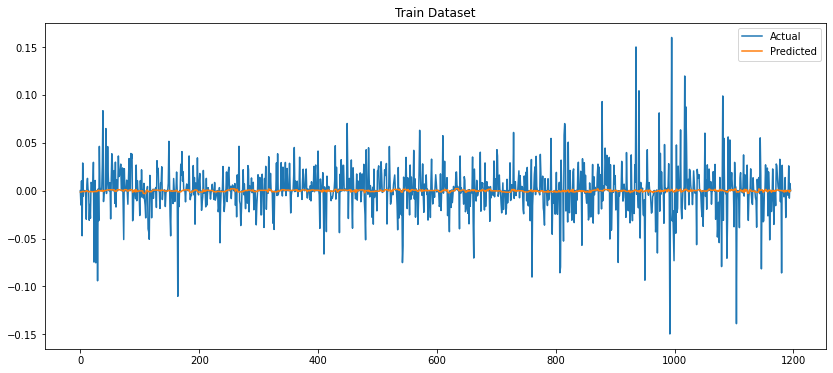

In [ ]:
plt.figure(figsize=(14,6))
 
y_hat_train = svr_cv.predict(X_train)
plt.plot(y_train, label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

In [ ]:
val_scores = svr_cv.cv_results_["mean_test_score"]
train_scores = svr_cv.cv_results_["mean_train_score"]
params = [str(x) for x in svr_cv.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

0.02389976940795174 0.020778643064592015 {'C': 0.001, 'degree': 9, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389976940795174 0.020778643064592015 {'C': 0.001, 'degree': 6, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389976940795174 0.020778643064592015 {'C': 0.001, 'degree': 3, 'epsilon': 0.001, 'gamma': 'auto'}
0.0239000320831715 0.020776487627034823 {'C': 0.001, 'degree': 9, 'epsilon': 0.001, 'gamma': 'scale'}
0.0239000320831715 0.020776487627034823 {'C': 0.001, 'degree': 6, 'epsilon': 0.001, 'gamma': 'scale'}
0.0239000320831715 0.020776487627034823 {'C': 0.001, 'degree': 3, 'epsilon': 0.001, 'gamma': 'scale'}
0.023902541224019913 0.02062865668132477 {'C': 0.001, 'degree': 9, 'epsilon': 0.001, 'gamma': 0.01}
0.023902541224019913 0.02062865668132477 {'C': 0.001, 'degree': 6, 'epsilon': 0.001, 'gamma': 0.01}
0.023902541224019913 0.02062865668132477 {'C': 0.001, 'degree': 3, 'epsilon': 0.001, 'gamma': 0.01}
0.023905463988091083 0.020527903107767795 {'C': 0.001, 'degree': 9, 'epsilon': 0.001, 'g

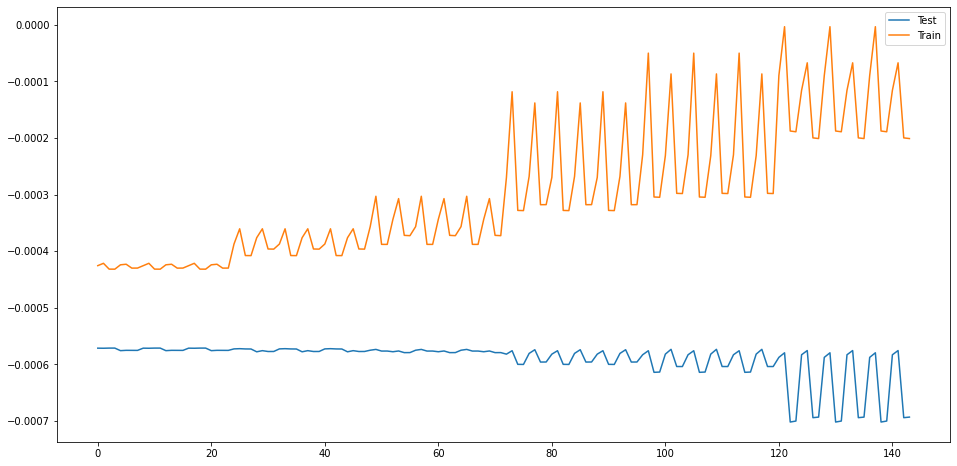

In [ ]:
pd.DataFrame({"Test": val_scores, "Train": train_scores}).plot(figsize=(16, 8))

Looks like it is underfitting. 

In [ ]:
dump(svr_cv.best_estimator_, "/content/drive/MyDrive/Dissertation Models/svr-1-Stock+USE.joblib")

['/content/drive/MyDrive/Dissertation Models/svr-1-Stock+USE.joblib']

## SVR 2 (BEST SVR)

In [ ]:
svr = SVR(kernel="rbf")

params = [
        {
            "C": [0.0001, 0.0005, 0.001, 0.003],
            "epsilon": [0.0005, 0.001, 0.005],
            "gamma": ["auto"], 
            "degree": [1, 2, 3, 4]
        }
        ]


tscv = TimeSeriesSplit(n_splits=5)
svr_cv = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
svr_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 120.467 seconds


In [ ]:
svr_cv.best_params_

{'C': 0.0005, 'degree': 1, 'epsilon': 0.001, 'gamma': 'auto'}

In [ ]:
print(f"RMSE CV: {np.sqrt(-svr_cv.best_score_)}")
print(f"MDA TRAINING SET: {get_mda(y_train, svr_cv.predict(X_train))}")

RMSE CV: 0.02389819450739133
MDA TRAINING SET: 0.6142259414225941


Text(0.5, 1.0, 'Train Dataset')

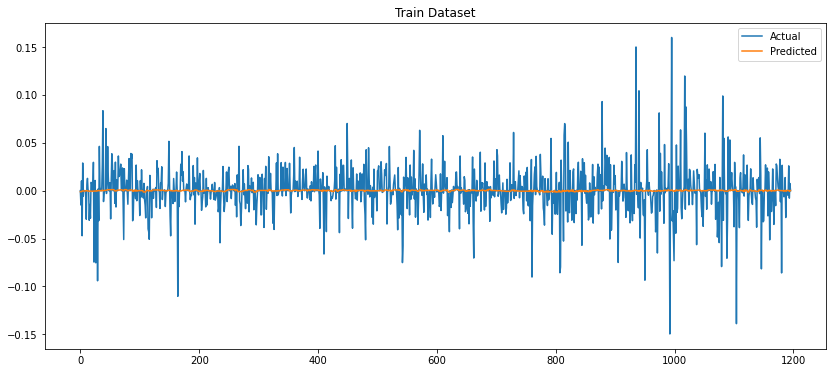

In [ ]:
plt.figure(figsize=(14,6))
 
y_hat_train = svr_cv.predict(X_train)
plt.plot(y_train, label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

In [ ]:
val_scores = svr_cv.cv_results_["mean_test_score"]
train_scores = svr_cv.cv_results_["mean_train_score"]
params = [str(x) for x in svr_cv.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

0.02389819450739133 0.020882116372471872 {'C': 0.0005, 'degree': 4, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389819450739133 0.020882116372471872 {'C': 0.0005, 'degree': 3, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389819450739133 0.020882116372471872 {'C': 0.0005, 'degree': 2, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389819450739133 0.020882116372471872 {'C': 0.0005, 'degree': 1, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389976940795174 0.020778643064592015 {'C': 0.001, 'degree': 4, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389976940795174 0.020778643064592015 {'C': 0.001, 'degree': 3, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389976940795174 0.020778643064592015 {'C': 0.001, 'degree': 2, 'epsilon': 0.001, 'gamma': 'auto'}
0.02389976940795174 0.020778643064592015 {'C': 0.001, 'degree': 1, 'epsilon': 0.001, 'gamma': 'auto'}
0.023903003813160587 0.02080600413772729 {'C': 0.001, 'degree': 4, 'epsilon': 0.0005, 'gamma': 'auto'}
0.023903003813160587 0.02080600413772729 {'C': 0.001, 'degree': 3, 'epsilon':

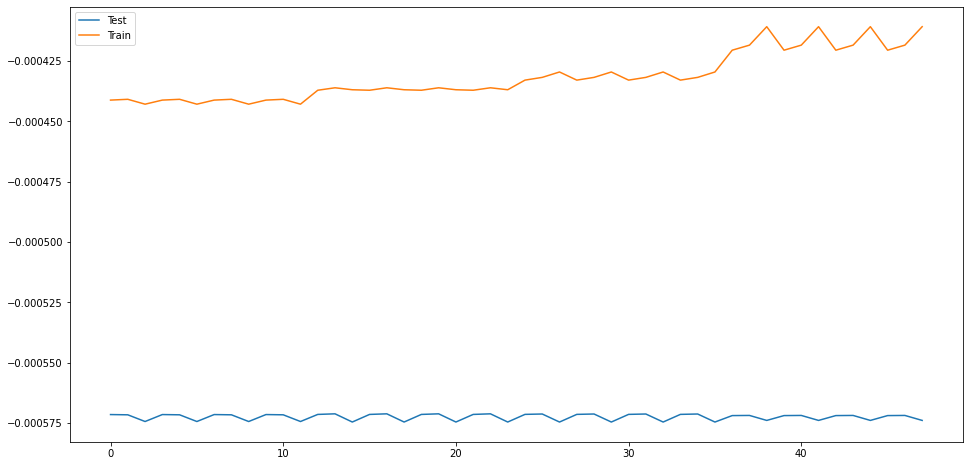

In [ ]:
pd.DataFrame({"Test": val_scores, "Train": train_scores}).plot(figsize=(16, 8))

Now it's too restricted and it has not been able to properrly learn from the training set. 

In [ ]:
dump(svr_cv.best_estimator_, "/content/drive/MyDrive/Dissertation Models/svr-2-Stock+USE.joblib")

['/content/drive/MyDrive/Dissertation Models/svr-2-Stock+USE.joblib']

## ADA 1 

In [ ]:
ada = AdaBoostRegressor(random_state=42)

params = {
        "n_estimators": [5, 10, 20, 30, 40], 
        'learning_rate': [0.5, 1, 1.5]
}

tscv = TimeSeriesSplit(n_splits=5)
ada_cv = GridSearchCV(estimator=ada, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
ada_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 65.886 seconds


In [ ]:
ada_cv.best_params_

{'learning_rate': 0.5, 'n_estimators': 5}

In [ ]:
print(f"RMSE CV: {np.sqrt(-ada_cv.best_score_)}")
print(f"MDA TRAINING SET: {get_mda(y_train, ada_cv.predict(X_train))}")

RMSE CV: 0.024167861320813448
MDA TRAINING SET: 0.20920502092050208


Text(0.5, 1.0, 'Train Dataset')

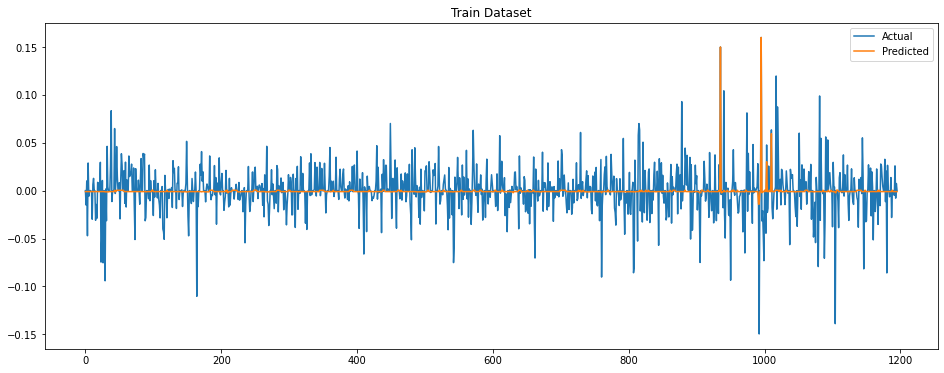

In [ ]:
plt.figure(figsize=(16,6))
 
y_hat_train = ada_cv.predict(X_train)
plt.plot(y_train, label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")


In [ ]:
val_scores = ada_cv.cv_results_["mean_test_score"]
train_scores = ada_cv.cv_results_["mean_train_score"]
params = [str(x) for x in ada_cv.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

0.024167861320813448 0.01893098554700334 {'learning_rate': 0.5, 'n_estimators': 5}
0.02417831394490028 0.018925483339042516 {'learning_rate': 1, 'n_estimators': 5}
0.024229057521489114 0.017644997112648473 {'learning_rate': 0.5, 'n_estimators': 20}
0.024239959775757845 0.01842453546204502 {'learning_rate': 0.5, 'n_estimators': 10}
0.024241096216936608 0.017871801128788695 {'learning_rate': 1, 'n_estimators': 10}
0.024329271779245445 0.017238709372500428 {'learning_rate': 0.5, 'n_estimators': 30}
0.02436032192841491 0.01677828718744313 {'learning_rate': 1, 'n_estimators': 30}
0.024386490854149488 0.017137311132608905 {'learning_rate': 1, 'n_estimators': 20}
0.024429656017534964 0.01699139482910242 {'learning_rate': 0.5, 'n_estimators': 40}
0.024525125765090656 0.016614005449377994 {'learning_rate': 1, 'n_estimators': 40}
0.02452699862240419 0.0183457565621724 {'learning_rate': 1.5, 'n_estimators': 5}
0.02459357004990065 0.01656258416257286 {'learning_rate': 1.5, 'n_estimators': 30}
0.02

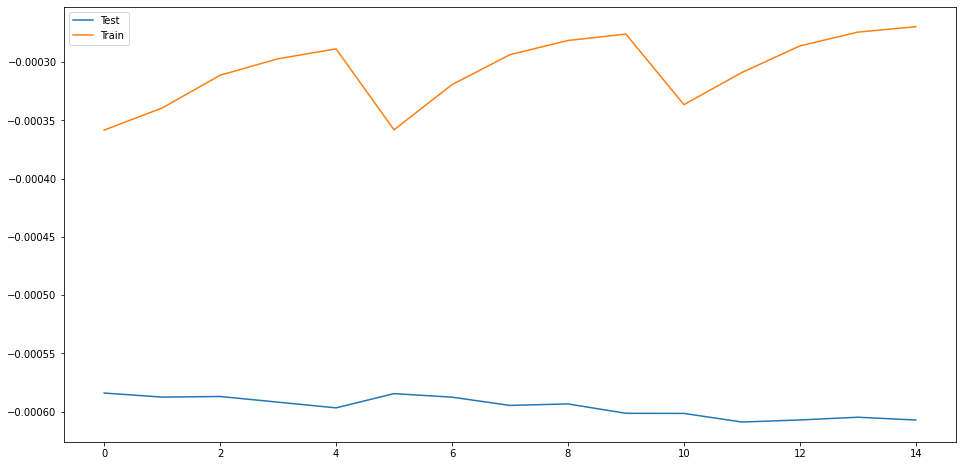

In [ ]:
pd.DataFrame({"Test": val_scores, "Train": train_scores}).plot(figsize=(16, 8))

In [ ]:
#Save the model
dump(ada_cv.best_estimator_, '/content/drive/MyDrive/Dissertation Models/ada-1-Stock+USE.joblib')

['/content/drive/MyDrive/Dissertation Models/ada-1-Stock+USE.joblib']

## XGBOST - BEST MDA OF ALL MODELS 63% - RMSE 0.025

In [ ]:
xgb = XGBRegressor(random_state=42, n_jobs=-1)

params = {
        "n_estimators": [50, 100, 150], 
        'max_depth': [5, None], 
    'min_child_weight': [1, 2]
}


tscv = TimeSeriesSplit(n_splits=5)
xgb_cv = GridSearchCV(estimator=xgb, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True, 
                        n_jobs=-1)

start = time.time()
xgb_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

[18:14:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Took 55.425 seconds


In [ ]:
xgb_cv.best_params_

{'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 50}

In [ ]:
print(f"RMSE CV: {np.sqrt(-xgb_cv.best_score_)}")
print(f"MDA TRAINING SET: {get_mda(y_train, xgb_cv.predict(X_train))}")

RMSE CV: 0.025693960603227744
MDA TRAINING SET: 0.6401673640167364


Text(0.5, 1.0, 'Train Dataset')

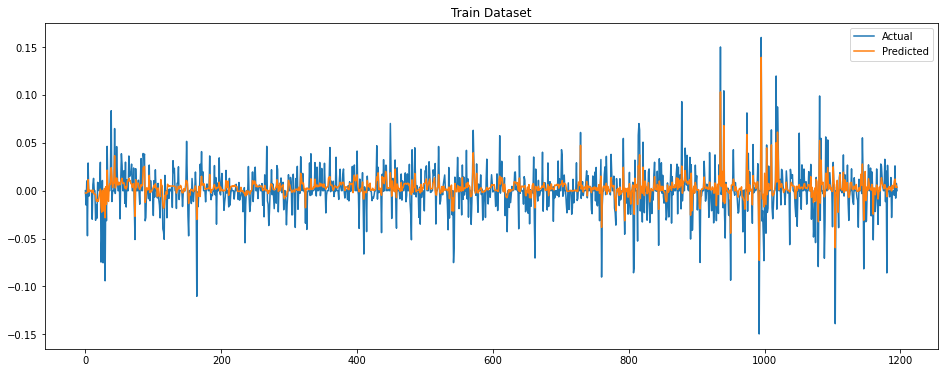

In [ ]:
plt.figure(figsize=(16,6))
 
y_hat_train = xgb_cv.predict(X_train)
plt.plot(y_train, label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

In [ ]:
val_scores = xgb_cv.cv_results_["mean_test_score"]
train_scores = xgb_cv.cv_results_["mean_train_score"]
params = [str(x) for x in xgb_cv.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

0.025693960603227744 0.012517842145389615 {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 50}
0.025729261102256994 0.007263865509016564 {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100}
0.02590089003742101 0.004459852924833597 {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 150}
0.026751956359407556 0.012201970566631696 {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50}
0.026969336414943205 0.006975654415659863 {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}
0.02718706863722451 0.004552661799739445 {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150}
nan nan {'max_depth': None, 'min_child_weight': 1, 'n_estimators': 50}
nan nan {'max_depth': None, 'min_child_weight': 1, 'n_estimators': 100}
nan nan {'max_depth': None, 'min_child_weight': 1, 'n_estimators': 150}
nan nan {'max_depth': None, 'min_child_weight': 2, 'n_estimators': 50}
nan nan {'max_depth': None, 'min_child_weight': 2, 'n_estimators': 100}
nan nan {'max_depth': None, 

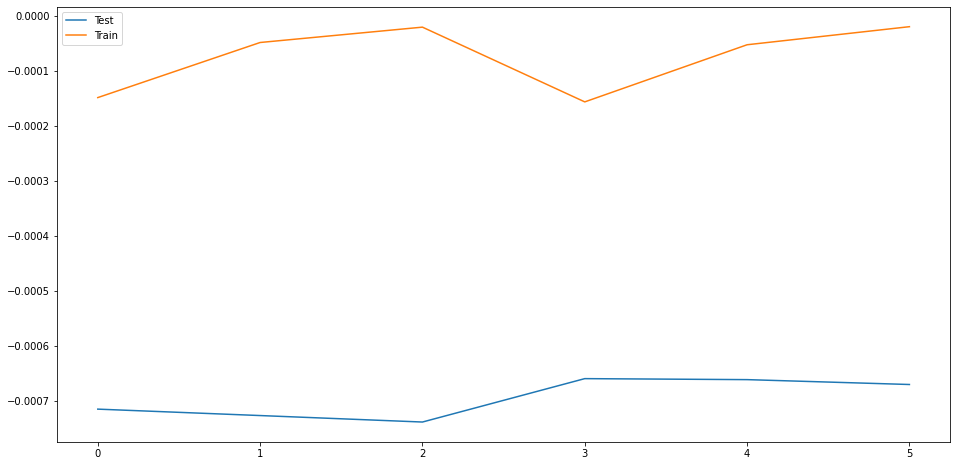

In [ ]:
pd.DataFrame({"Test": val_scores, "Train": train_scores}).plot(figsize=(16, 8))

In [ ]:
#Save the model
dump(xgb_cv.best_estimator_, '/content/drive/MyDrive/Dissertation Models/xgb-1-Stock+USE.joblib')

['/content/drive/MyDrive/Dissertation Models/xgb-1-Stock+USE.joblib']

## XGBOOST 2 

In [ ]:
xgb = XGBRegressor(random_state=42, n_jobs=-1)

params = {
        "n_estimators": [30, 40, 50, 60, 70, 80], 
        'max_depth': [3, 5, 7, ], 
        'min_child_weight': [1, 2]
}


tscv = TimeSeriesSplit(n_splits=5)
xgb_cv = GridSearchCV(estimator=xgb, cv=tscv,
                        param_grid=params,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True, 
                        n_jobs=-1)

start = time.time()
xgb_cv.fit(X_train, y_train)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

[18:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Took 147.747 seconds


In [ ]:
xgb_cv.best_params_

{'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 60}

In [ ]:
print(f"RMSE CV: {np.sqrt(-xgb_cv.best_score_)}")
print(f"MDA TRAINING SET: {get_mda(y_train, xgb_cv.predict(X_train))}")

RMSE CV: 0.025393391595668495
MDA TRAINING SET: 0.4887029288702929


Text(0.5, 1.0, 'Train Dataset')

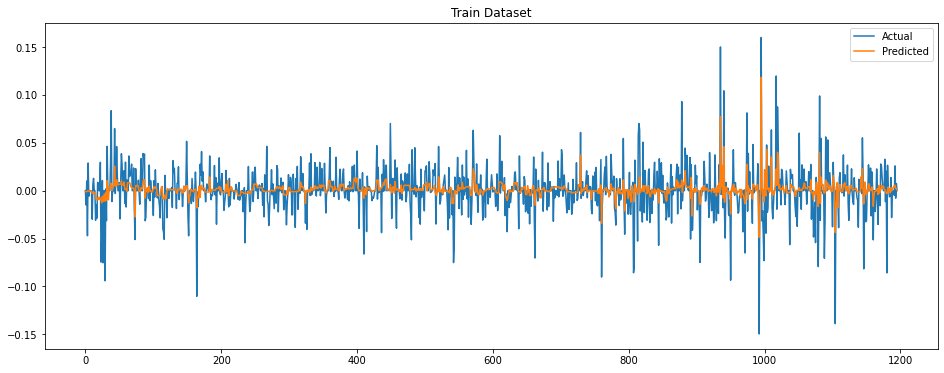

In [ ]:
plt.figure(figsize=(16,6))
 
y_hat_train = xgb_cv.predict(X_train)
plt.plot(y_train, label="Actual")
plt.plot((y_hat_train), label="Predicted")
plt.legend()
plt.title("Train Dataset")

In [ ]:
val_scores = xgb_cv.cv_results_["mean_test_score"]
train_scores = xgb_cv.cv_results_["mean_train_score"]
params = [str(x) for x in xgb_cv.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

0.025393391595668495 0.014989809502678416 {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 60}
0.025425612823773914 0.009603163513749484 {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 70}
0.025459716451955203 0.010865605536544235 {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 60}
0.02547151873078336 0.016050382461404732 {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
0.025490655820966997 0.008739613005735312 {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 80}
0.025526182247756022 0.014276346447830905 {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 70}
0.02560820508629014 0.013579732260741554 {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 80}
0.025693960603227744 0.012517842145389615 {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 50}
0.025923861331933407 0.014955975758353536 {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 60}
0.02601019363634476 0.005921089199095303 {'max_depth': 7, 'min_child_weight': 2, 'n_

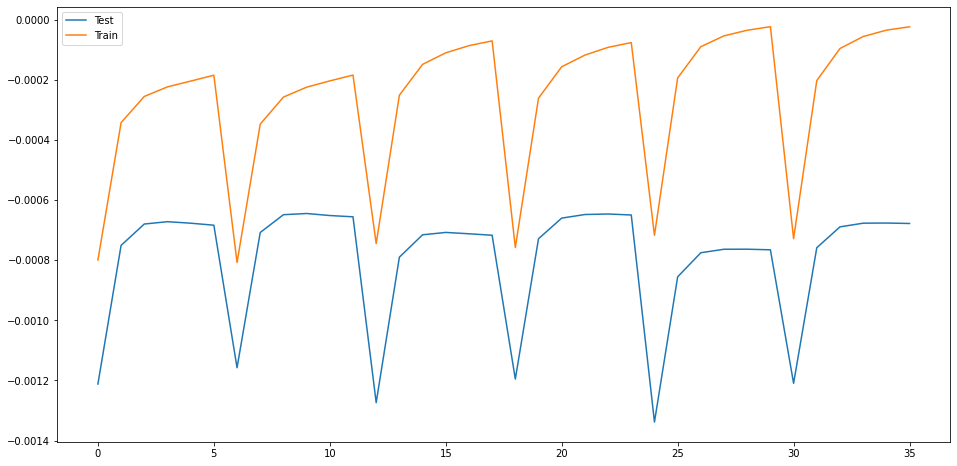

In [ ]:
pd.DataFrame({"Test": val_scores, "Train": train_scores}).plot(figsize=(16, 8))


In [ ]:
#Save the model
dump(xgb_cv.best_estimator_, '/content/drive/MyDrive/Dissertation Models/xgb-2-Stock+USE.joblib')

['/content/drive/MyDrive/Dissertation Models/xgb-2-Stock+USE.joblib']

# Best Model Evaluation 

In [ ]:
svr = load("/content/drive/MyDrive/Dissertation Models/svr-2-Stock+USE.joblib")
ada = load("/content/drive/MyDrive/Dissertation Models/ada-1-Stock+USE.joblib")
xgb = load("/content/drive/MyDrive/Dissertation Models/xgb-1-Stock+USE.joblib")

[18:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# SVR Evaluation
y_hat_svr = svr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_hat_svr))
mda = get_mda(y_test, y_hat_svr)
print(f"SVR - RMSE: {rmse}")
print(f"SVR - MDA: {mda}")
print("")

# ADA Evaluation
y_hat_ada = ada.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_hat_ada))
mda = get_mda(y_test, y_hat_ada)
print(f"ADA - RMSE: {rmse}")
print(f"ADA - MDA: {mda}")
print("")

# XGBOOST Evaluation
y_hat_xgb = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_hat_xgb))
mda = get_mda(y_test, y_hat_xgb)
print(f"ADA - RMSE: {rmse}")
print(f"ADA - MDA: {mda}")

SVR - RMSE: 0.02607389988305052
SVR - MDA: 0.5275590551181102

ADA - RMSE: 0.026079582496631164
ADA - MDA: 0.25196850393700787

ADA - RMSE: 0.02702834891113511
ADA - MDA: 0.4881889763779528


Text(0.5, 1.0, 'XGB Evaluation')

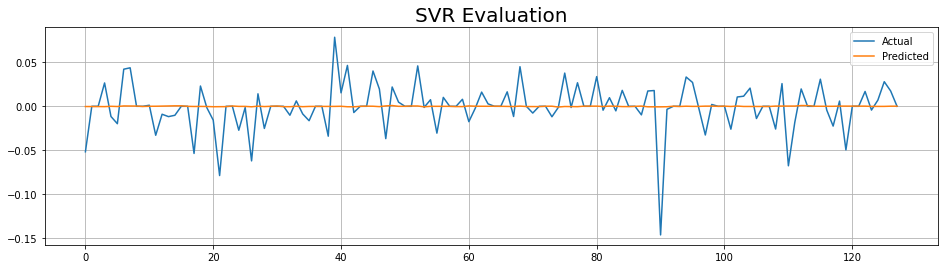

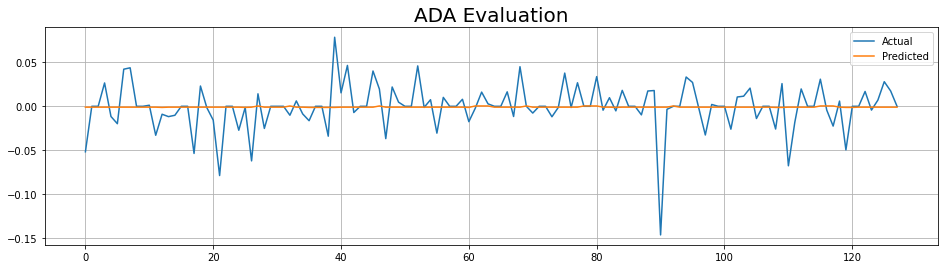

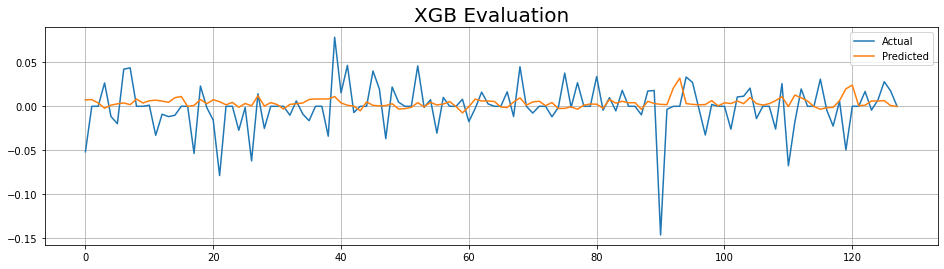

In [ ]:
plt.subplot2grid

plt.figure(figsize=(16,4))

plt.plot(y_test, label="Actual")
plt.plot((y_hat_svr), label="Predicted")
plt.legend()
plt.grid()
plt.title("SVR Evaluation", fontsize=20)

plt.figure(figsize=(16,4))

plt.plot(y_test, label="Actual")
plt.plot((y_hat_ada), label="Predicted")
plt.legend()
plt.grid()
plt.title("ADA Evaluation", fontsize=20)

plt.figure(figsize=(16,4))

plt.plot(y_test, label="Actual")
plt.plot((y_hat_xgb), label="Predicted")
plt.legend()
plt.grid()
plt.title("XGB Evaluation", fontsize=20)